2024_15_08_16_07_11


,start_time,experiment_group_id,sequence_length,best_dev_loss,best_dev_f1,robust,wd,widthi,depthi,batch_size,early_stopping,execution_time,trainlossi,testlossi
0,2024_15_08_16_07_11,downsampling,NaN,0.2348,NaN,False,0.01,"[16, 32, 64, 128]","[1, 1, 1, 1]",512,NaN,15.785657,"[0.3377570891453896, 0.2687510444426242, 0.261...","[0.2790947325251721, 0.3016217667195532, 0.277..."


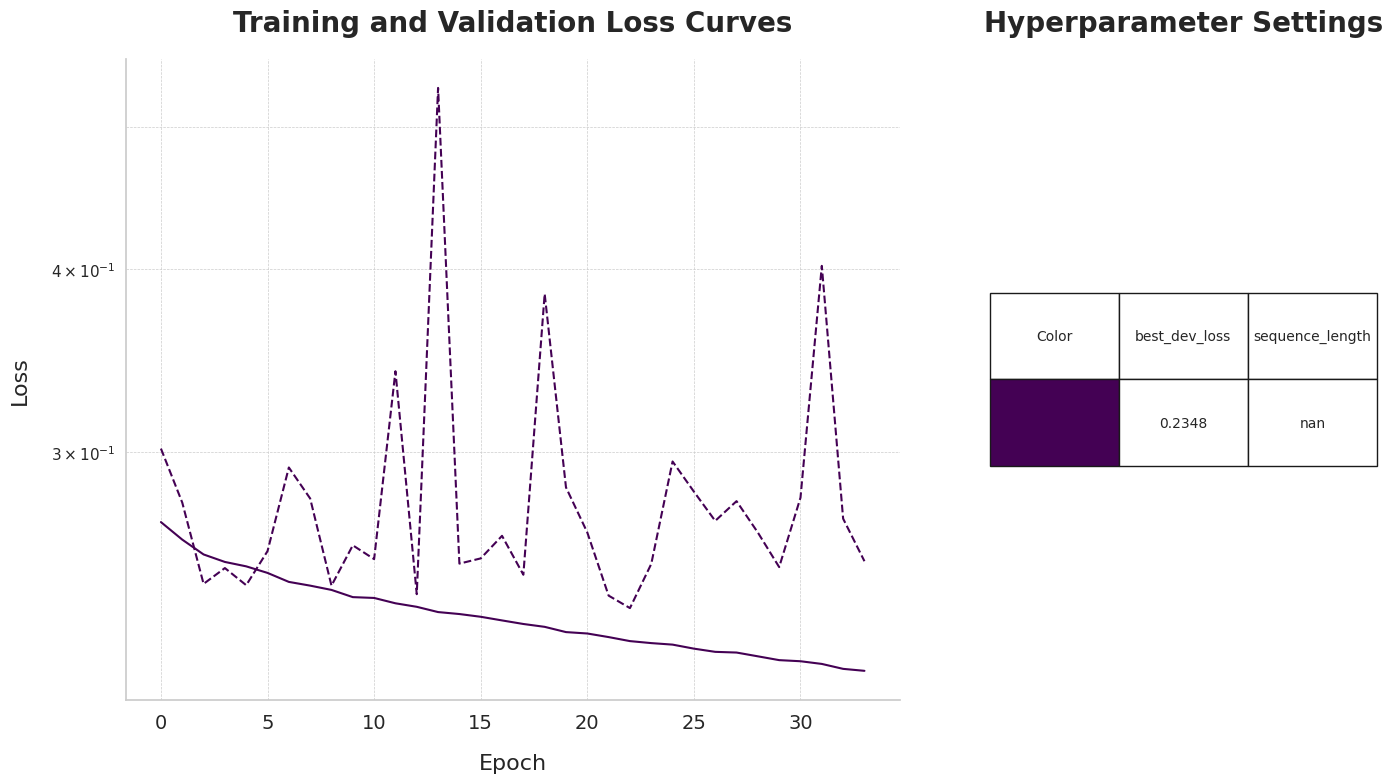

In [1]:
from lib.ekyn import *
from lib.env import *
from sage.utils import *
from sage.models import *
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
import pandas as pd
import os

states = {}
for experiment in os.listdir(f'{EXPERIMENTS_PATH}'):
    print(experiment)
    state = torch.load(f'{EXPERIMENTS_PATH}/{experiment}/state.pt',weights_only=False)
    states[experiment] = state
df = pd.DataFrame([states[experiment] for experiment in states],columns=['start_time','experiment_group_id','sequence_length','best_dev_loss','best_dev_f1','robust','wd','widthi','depthi','batch_size','early_stopping','execution_time','trainlossi','testlossi']).sort_values(by='start_time',ascending=False)
df.reset_index(drop=True,inplace=True)
# plot_train_and_test_loss_in_plotly(df.loc[[18,17,16,15,9]])
df = df.iloc[:5]
display(df)
plot_loss_curves(df,moving_window_length=1)

In [ ]:
df.sort_values(by='best_dev_loss')

['F1-0', 'B3-1', 'A4-0', 'F1-1', 'E2-1', 'C4-1', 'F5-1', 'E4-0', 'B1-0', 'A1-0', 'C1-0', 'E4-1'] ['A1-1', 'C4-0', 'D1-0', 'E1-0']
train_ids ['F1-0', 'B3-1', 'A4-0', 'F1-1', 'E2-1', 'C4-1', 'F5-1', 'E4-0', 'B1-0', 'A1-0', 'C1-0', 'E4-1']
test_ids ['A1-1', 'C4-0', 'D1-0', 'E1-0']
n ids 16
405 training batches 135 testing batches
207360 training samples 69120 testing samples
576.00 training hours 192.00 testing hours


Text(0.5, 1.0, 'f1 : 0.825')

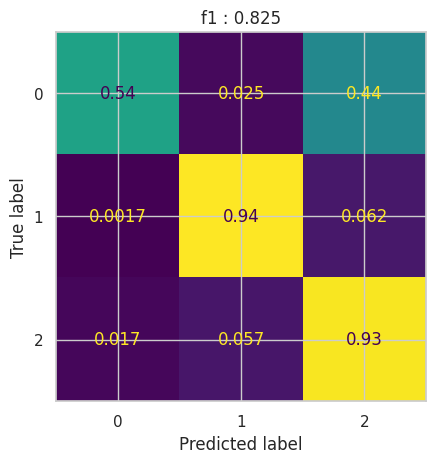

In [3]:
from sklearn.model_selection import train_test_split
from lib.ekyn import *

MODEL_ID = 0

ekyn_ids = get_ekyn_ids()
train_ids,test_ids = train_test_split(ekyn_ids,test_size=.2,shuffle=True,random_state=0)
print(train_ids,test_ids)
state = torch.load(f'{EXPERIMENTS_PATH}/{df.loc[MODEL_ID,"start_time"]}/state.pt',weights_only=False)
model = copy.deepcopy(state['model'])
model.load_state_dict(state['best_model_wts'])
# trainloader,testloader = get_sequenced_dataloaders(batch_size=state['batch_size'],sequence_length=state['sequence_length'])
trainloader,testloader = get_epoched_dataloaders(batch_size=state['batch_size'],robust=False)
loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',colorbar=False)
plt.title(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Assuming df is populated with necessary data
df = {}

# Initialize the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

# Loop through test IDs
for id in test_ids:
    # Load data and perform necessary calculations
    X, y = load_ekyn_pt(id=id, condition='PF')

    # ECDF plot
    std, mean = torch.std_mean(X[torch.where(y.argmax(axis=1) == 1)[0]], dim=1)
    sns.ecdfplot(std, linewidth=2, label=id, ax=axes[0])

    # Calculate F1 score
    dataloader = get_epoched_dataloader_for_ids(ids=[id],robust=state['robust'])
    loss, y_true, y_pred = evaluate(dataloader=dataloader, model=model, criterion=state['criterion'], device='cuda')
    f1 = float(f1_score(y_true, y_pred, average="macro"))

    # Bar plot
    sns.barplot(x=[id], y=[f1], ax=axes[1])  # Plotting F1 score for each ID


# for id in train_ids:
#     # Load data and perform necessary calculations
#     X, y = load_ekyn_pt(id=id, condition='PF')

#     # ECDF plot
#     std, mean = torch.std_mean(X[torch.where(y.argmax(axis=1) == 1)[0]], dim=1)
#     sns.ecdfplot(std, linewidth=.5, label=id, ax=axes[0],color='black')

# Final adjustments
axes[0].legend()
axes[0].set_xlim([0, .000150])
axes[1].set_ylim([0, 1])  # Adjust y-axis limits for the bar plot

# Display the plot
plt.tight_layout()
plt.show()
